# Иссладование результатов А/А/В теста

##  Описание поекта

В проекте осуществляется работа с данными стартапа, который продаёт продукты питания. Изучено, как ведут себя пользователи мобильного приложения. \
Исследованы результаты A/A/B-эксперимента. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import math as mth
import plotly.express as px
from plotly import graph_objects as go

In [4]:
logs = pd.read_csv('/Users/mariiapolnikova/Desktop/data analysis/logs_exp.csv', sep='\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# назовем столбцы так, чтобы было понятно, какие данные в них находятся
logs.columns = ['event_name', 'user_id', 'timestamp', 'group']

In [6]:
# приведем столбец с датой и временем к нужному формату и добавим стобец с датой события
logs['timestamp'] = pd.to_datetime(logs['timestamp'], unit='s')
logs['event_dt'] = pd.to_datetime(logs['timestamp']).dt.date

In [7]:
# проверим пропуски и типы данных и откорректируем, если нужно
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   timestamp   244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   event_dt    244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


In [8]:
# с типами данных все ок, проверим данные на дубликаты
logs.duplicated().sum()

413

In [9]:
# удалим дубликаты
logs = logs.drop_duplicates().reset_index()

In [12]:
# проверим, есь ли пользователи, которые попали в несколько рассматриваемых экспериментов
logs.groupby('user_id', as_index=False)['group'].nunique()[logs.groupby('user_id', as_index=False)['group']
                                                           .nunique()['group'] > 1]

,user_id,group


In [13]:
# таких пользоватаелей нет.Теперь данные готовы к анализу
logs.head()

,index,event_name,user_id,timestamp,group,event_dt
0,0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [14]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   index       243713 non-null  int64         
 1   event_name  243713 non-null  object        
 2   user_id     243713 non-null  int64         
 3   timestamp   243713 non-null  datetime64[ns]
 4   group       243713 non-null  int64         
 5   event_dt    243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


В подготовленных данных нет пропусков, нет дубликатов. Названия столбцов приведены к удобному для использования виду. Столбцы с датой и временем приведены к типу datetime.

## Знакомство с данными

Сколько всего событий в логе? Проверим какие есть события.

In [15]:
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [16]:
logs['event_name'].nunique()

5

Всего в логах 5 событий. Это переход на главный экран, переход на страницу с предложениями, переход в корзину, обучение и переход на страницу с успешной оплатой.

Проверим,сколько всего пользователей в логе

In [17]:
logs['user_id'].nunique()

7551

В данных изучим логи 7551 пользователей. Сколько в среднем событий приходится на пользователя?

In [18]:
logs.groupby('user_id')['event_name'].count().mean()

32.27559263673685

В среднем на пользователя приходится 32 события. Посмотрим на распределение количества событий по пользователям

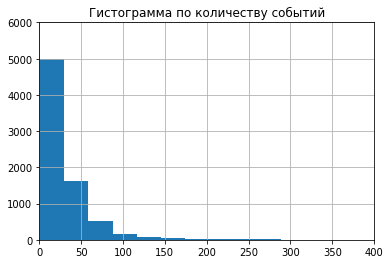

In [19]:
logs.groupby('user_id')['event_name'].count().hist(bins=80)
plt.title('Гистограмма по количеству событий')
plt.axis([0, 400, 0,6000])
plt.show()

Большинство пользоватлей совершают не более 50 событий. Тем не менее есть пользователи, количество событий кторых доходит до двухсот.

Проверим, данными за какой период мы располагаем.Найдем максимальную и минимальную дату.

In [20]:
logs['event_dt'].min()

datetime.date(2019, 7, 25)

In [21]:
logs['event_dt'].max()

datetime.date(2019, 8, 7)

У нас есть данные с 25-07-2019 по 07-08-2019. Теперь построим гистограмму по дате и времени.

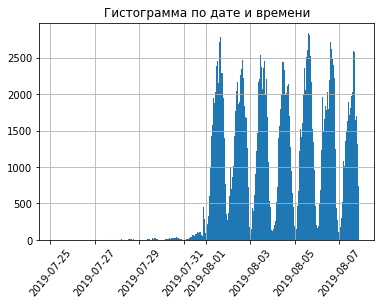

In [22]:
logs['timestamp'].hist(bins=14*24)
plt.title('Гистограмма по дате и времени')
plt.xticks(rotation=50)
plt.show()

Исходя из гистограммы можно увидеть, что у нас не одинаково полные данные за весь период. Полные данные предоставлены с 01-08-2018 , отбросим более старые данные. Получается, что на самом деле мы будем рассматривать данные за первую неделю августа 2019 года.

In [23]:
filtered_logs = logs.query('timestamp >= "2019-08-01 00:00"')

Проверим, много ли событий и пользователей мы потеряли, отбросив старые данные.

In [24]:
# проверим количество потерянных пользователей
logs['user_id'].nunique()-filtered_logs['user_id'].nunique()

17

In [25]:
round((1-filtered_logs['user_id'].nunique()/logs['user_id'].nunique())*100,2)

0.23

In [26]:
# проверим количество потерянных событий
logs['user_id'].count()-filtered_logs['user_id'].count()

2826

In [27]:
round((1-filtered_logs['user_id'].count()/logs['user_id'].count())*100,2)

1.16

Отбросив данные мы потеряли 17 пользователя, что составляет 0,23%, также было потеряно 2826 событие, что составляет 1,16% от общего числа.Потери незначительны.

Проверим количество пользователей из всех экспериментальных групп.

In [28]:
logs.groupby('group')['user_id'].nunique()

group
246    2489
247    2520
248    2542
Name: user_id, dtype: int64

Пользователи есть во всех трех изучаемых группах. Теперь можем перейти к анализу.

## Воронка событий

Посмотрим, как часто встречаются разного вида события в логах. Отсортируем события по частоте.

In [29]:
filtered_logs.groupby('event_name')['user_id'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: user_id, dtype: int64

Больше всего событий перехода на главных экран, что логично,так как с него нчинается взаимодействие с приложением. После него по часттоте идет страница с предложениями, после чего страница корзины и потом страница с успешной покупкой. Интересно,что событие с обучением появляется всего 1005 раз. Возможно это связано с тем, что приложение и так простое в использовании, поэтому обучение пользователям не нужно. \
Удалим данные о событиях , связанных с туториалом, так как эта информация нам не пригодится.Она не вписывается в воронку.

In [30]:
filtered_logs = filtered_logs[filtered_logs['event_name'] != 'Tutorial' ]

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 

In [31]:
unique_users = filtered_logs.groupby('event_name', as_index=False)['user_id'].nunique().sort_values(by='user_id',ascending=False)
unique_users.columns=['event_name', 'unique_users']
unique_users['share, %'] = round(unique_users['unique_users']/filtered_logs['user_id'].nunique()*100,2)
unique_users

,event_name,unique_users,"share, %"
1,MainScreenAppear,7419,98.53
2,OffersScreenAppear,4593,61.00
0,CartScreenAppear,3734,49.59
3,PaymentScreenSuccessful,3539,47.00


По результатам видно, что с окна главного меню на окно выбора продуктов переходят не все. Только 61% юзеров от общего количества переходят к просмотру товара, нужно отследить, почему на этом этапе такой большой отток. В целом, 47% всех пользоваталей доходят до успешного совершения покупки в магазине.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [33]:
unique_users['cumulative_share'] = round(unique_users['unique_users']/unique_users['unique_users']
                                         .shift(1,fill_value=filtered_logs['user_id'].nunique())*100,2)
unique_users

,event_name,unique_users,"share, %",cumulative_share
1,MainScreenAppear,7419,98.53,98.53
2,OffersScreenAppear,4593,61.00,61.91
0,CartScreenAppear,3734,49.59,81.30
3,PaymentScreenSuccessful,3539,47.00,94.78


По доле пользователей, которые переходят на следующий шаг, мы опять видим то, что с главной страницы лишь 62 процента переходят на страницу с товарами. А вот из тех, кто все-таки перешел, в корзину переходит 81%, это хороший показатель.

Посчитаем, какая доля пользователей доходит от первого события до оплаты.

In [34]:
round(unique_users['unique_users']/unique_users['unique_users'].shift(3,fill_value=0)*100, 2)

1     inf
2     inf
0     inf
3    47.7
Name: unique_users, dtype: float64

Всего 48 процентов пользователей доходят до окна оплаты при пользовании приложением. Визуализируем воронку:

In [37]:
fig = go.Figure(go.Funnel( x=unique_users['unique_users'], y=unique_users['event_name'],
                          textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка событий')
fig.show()

## А/А/В эксперимент

У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Для этого используем Z-тест

Сформулируем гиптезы и применим Z тест: \
Н0: доли уникальных посетителей, побывавших на этапе воронки, одинаковы. \
Н1: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

Выберем самое популярное событие. В нашем случае это событие перехода на главную страницу "MainScreenAppear". Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [38]:
users_groups = filtered_logs.pivot_table(
    index='event_name', columns='group', values='user_id', aggfunc='nunique', margins=True
    ).sort_values(by='All', ascending=False)
users_groups['totalA'] = users_groups[246]+users_groups[247]
users_groups['246_%'] = round(users_groups[246]/filtered_logs['user_id'].nunique()*100,2)
users_groups['247_%'] = round(users_groups[247]/filtered_logs['user_id'].nunique()*100,2)
users_groups

group,246,247,248,All,totalA,246_%,247_%
event_name,,,,,,,
All,2483,2512,2535,7530,4995,32.97,33.36
MainScreenAppear,2450,2476,2493,7419,4926,32.54,32.88
OffersScreenAppear,1542,1520,1531,4593,3062,20.48,20.19
CartScreenAppear,1266,1238,1230,3734,2504,16.81,16.44
PaymentScreenSuccessful,1200,1158,1181,3539,2358,15.94,15.38


По долям контрольных групп можем увидеть, что различие в количестве пользователей небольшое. Проверим это спомощью zтеста.

Н0: нет отличий между долями групп А1 и А2, совершивших событие MainScreenAppear \
Н1: есть отличия между долями контрольных групп

In [39]:
alpha = .05 # критический уровень статистической значимости

# кол-во пользователей группах А
visits = np.array([users_groups[246]['All'], users_groups[247]['All']])

# кол-во пользователей, посетивших главную страницу в группах А
users = np.array([users_groups[246]['MainScreenAppear'], users_groups[247]['MainScreenAppear']])

stat, p_value = proportions_ztest(users, visits, alternative='two-sided')

print('p-value = {:.3f}'.format(p_value))
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными'
    ) 

p-value = 0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными


Проделаем то же самое для всех других событий.

In [40]:
def ztest (group1, group2, event, alpha=.05):
    users = np.array([users_groups[group1]['All'], users_groups[group2]['All']])
    buyers = np.array([users_groups[group1][event], users_groups[group2][event]])
    stat, p_value = proportions_ztest(buyers, users, alternative='two-sided')
    print('p-value = {:.3f}'.format(p_value))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными'
        ) 

In [41]:
for i in filtered_logs['event_name'].unique():
    print('Для контрольных групп и события ', i)
    ztest(246,247, i, alpha/4) # уровень значимости делим 
    # на количество гипотез по методу Бонферрони

Для контрольных групп и события  MainScreenAppear
p-value = 0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для контрольных групп и события  OffersScreenAppear
p-value = 0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для контрольных групп и события  CartScreenAppear
p-value = 0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для контрольных групп и события  PaymentScreenSuccessful
p-value = 0.114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными


Исходя из результатов теста, можем сделать вывод, что разбиение на группы работает корректно

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Уровень значимости 0.5 поделим на количество гипотез по методу Бонферрони

In [42]:
for i in filtered_logs['event_name'].unique():
    for j in [246, 247, 'totalA']:
        print('Для групп 248 и', j, 'и события ', i )
        ztest(j, 248, i, alpha/16) # уровень значимости делим 
        # на количество гипотез по методу Бонферрони

Для групп 248 и 246 и события  MainScreenAppear
p-value = 0.339
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для групп 248 и 247 и события  MainScreenAppear
p-value = 0.519
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для групп 248 и totalA и события  MainScreenAppear
p-value = 0.349
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для групп 248 и 246 и события  OffersScreenAppear
p-value = 0.214
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для групп 248 и 247 и события  OffersScreenAppear
p-value = 0.933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для групп 248 и totalA и события  OffersScreenAppear
p-value = 0.446
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Для групп 248 и 246 и события  CartScreenAppear
p-value = 0.081
Не получилось отвергнуть нулевую гипотезу, нет основан

Из данного эксперимента мы можем сделать вывод, что статистической разницы между группами А/А/В нет.

## Выводы

В данном проекте мы провели А/А/В тест и выяснили, стоит ли дизайнерам поменять шрифты во всём приложении и повлияет ли это на количество покупателей товаров. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

В первом разделе мы предобработали данные, приведя данные к нужному типу и удалив дубликаты.

Далее мы изучили данные и выяснили, что у нас не одинаково полные данные за весь период. Полные данные предоставлены с 01-08-2018. Получается, что на самом деле мы будем рассматривать данные за первую неделю августа 2019 года. Также мы проверили, что во всех группах (двух контрольных и одной экспериментальной) есть данные о пользователях.

Далее мы изучили воронку событий. Было выяснено, что всего мы рассматривем 4 главных события. Это переход на главную страницу приложения, переход к просмотру товаров, переход в корзину, переход на страницу с успешной покупкой.

Далее мы проверили корректность всех механизмов и расчётов. С помощью Z-тест мы доказали, что статистически значимой разницы между контрольными группами 246 и 247 нет.

После этого мы выбрали самое популярное событие. В нашем случае это событие перехода на главную страницу "MainScreenAppear". И проверили, будет ли отличие между группами статистически достоверным. \
Н0: нет отличий между долями групп А1 и А2, совершивших событие MainScreenAppear \
Н1: есть отличия между долями контрольных групп

p-value оказался равен 0.753, что меньше уровня значимости.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

Далее мы проделали то же самое для всех событий воронки и не смогли отвергнуть нулевую гипотезу ни для одного из событий.

Аналогично поступили с группой с изменённым шрифтом. Сравнили результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнили результаты с объединённой контрольной группой.

Важно заметить, что для данных тестов мы использовали метод Бонферони, разделили уровень значимости на число гипотез.

Из результатов проведенных тестов можно сделать вывод, что группа В не имеет статистически значимых различий ни с одной из групп А ни в одном из событий. Это значит, что при изменении шрифта приложения ничего не изменится и пользователи не изменят своего поведения.
Тест можно считать завершенным. А/А/В тест оказался неудачным.